## Install Required Dependencies for Colab

In [ ]:
!pip install py2neo

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [2]:
!wget -q https://archive.apache.org/dist/spark/spark-3.0.0/spark-3.0.0-bin-hadoop3.2.tgz

In [3]:
!tar xf spark-3.0.0-bin-hadoop3.2.tgz

In [ ]:
!pip install findspark

In [ ]:
!pip install pyspark

## Load the data into neo4j and process it for making the co-authorship graph

- **Load the data**

`
CALL apoc.periodic.iterate(
'UNWIND ["dblp-ref-0.json","dblp-ref-1.json",
"dblp-ref-2.json","dblp-ref-3.json"] AS file
CALL apoc.load.json("file:///" + file)
YIELD value
WHERE value.venue IN ["Lecture Notes in Computer Science",
"Communications of The ACM",
"international conference on software engineering",
"advances in computing and communications"]
return value',
'MERGE (a:Article {index:value.id})
ON CREATE SET a += apoc.map.clean(value,["id","authors","references"],[0])
WITH a,value.authors as authors
UNWIND authors as author
MERGE (b:Author{name:author})
MERGE (b)<-[:AUTHOR]-(a)'
, {batchSize: 10000, iterateList: true});
`

- **Constrcut the co-authorship Graph (considered undirected)**

`
MATCH (a1)<-[:AUTHOR]-(paper)-[:AUTHOR]->(a2:Author)
WITH a1, a2, paper
ORDER BY a1, paper.year
WITH a1, a2, collect(paper)[0].year AS year, count(*) AS collaborations
MERGE (a1)-[coauthor:CO_AUTHOR {year: year}]-(a2)
SET coauthor.collaborations = collaborations;
`



## Import the required packages

In [7]:
from py2neo import Graph

In [8]:
import pandas as pd
from numpy.random import randint

In [9]:
from pyspark.ml import Pipeline
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [10]:
from sklearn.metrics import roc_curve, auc
from collections import Counter

In [11]:
from cycler import cycler
import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

In [12]:
# Insert required bolt port and authentication details
graph = Graph("bolt://thisismatrix.centralindia.cloudapp.azure.com:7687", auth=("neo4j", "neo4j"))

In [14]:
from pyspark.context import SparkContext
from pyspark.sql.session import SparkSession
sc = SparkContext('local')
spark = SparkSession(sc)

## Split for train and test sets

- There is a time (year) property in the data.
- We can split the data based on some year.
- For the present data, 2006 seems to be good for split. (See the graph below)

In [15]:
query = """
MATCH (article:Article)
RETURN article.year AS year, count(*) AS count
ORDER BY year
"""
by_year = graph.run(query).to_data_frame()

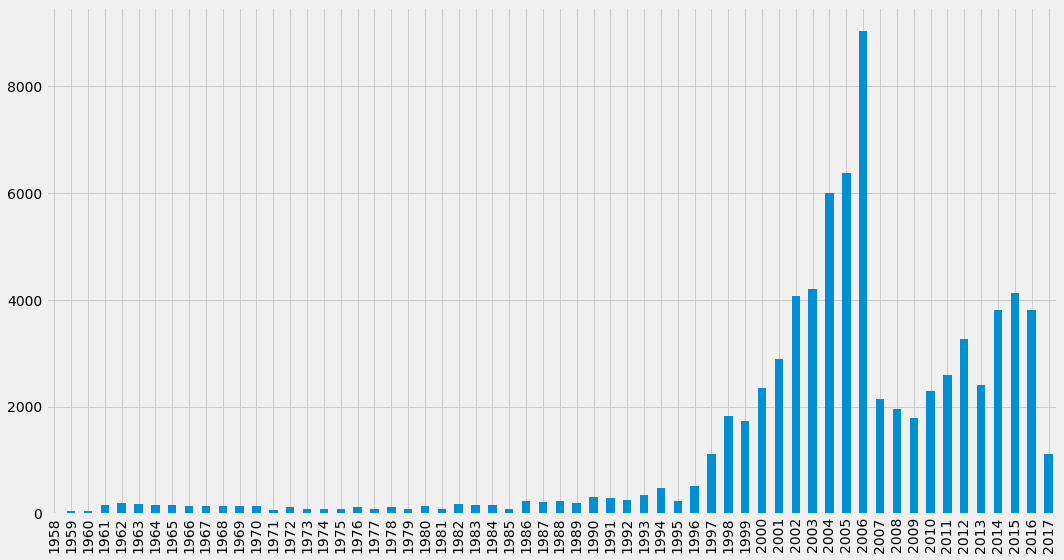

In [16]:
%matplotlib inline
plt.style.use('fivethirtyeight')
ax = by_year.plot(kind='bar', x='year', y='count', legend=None, figsize=(15,8))
ax.xaxis.set_label_text("")
plt.tight_layout()
plt.show()

### Construct graphs for co-authors before and after 2006

- **Co-author graph before 2006**.

`
MATCH (a1)-[coAuthor:CO_AUTHOR]-(a2:Author)
WHERE coAuthor.year < 2006
MERGE (a1)-[coauthorEarly:CO_AUTHOR_EARLY {year: coAuthor.year}]-(a2)
SET coauthorEarly.collaborations = coAuthor.collaborations;
`

- **Co-author graph after 2006**.

`
MATCH (a1)-[coAuthor:CO_AUTHOR]-(a2:Author)
WHERE coAuthor.year >= 2006
MERGE (a1)-[coauthorLate:CO_AUTHOR_LATE {year: coAuthor.year}]-(a2)
SET coauthorLate.collaborations = coAuthor.collaborations;
`

### Down Sample the sets for tackling class imbalance problem

- For training set, use co-author graph before 2006 (CO_AUTHOR_EARLY).
    - Get the positive edges (with label 1) directly.
    - Get the negative edges (with label 0) 2..3 hops away.
    - Will have to downsample in order to bring down this number.
- For test set, use co-author graph after 2006 (CO_AUTHOR_LATE).
    - Get the positive edges (with label 1) directly.
    - Get the negative edges (with label 0) 2..3 hops away.
    - Will have to downsample in order to bring down this number.

In [17]:
def down_sample(df):
    copy = df.copy()
    zero = Counter(copy.label.values)[0]
    un = Counter(copy.label.values)[1]
    n = zero - un
    copy = copy.drop(copy[copy.label == 0].sample(n=n, random_state=1).index)
    return copy.sample(frac=1)

In [18]:
train_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_EARLY]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

In [19]:
train_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_EARLY]-()
MATCH (author)-[:CO_AUTHOR_EARLY*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR_EARLY]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()

In [20]:
train_missing_links = train_missing_links.drop_duplicates()
training_df = train_missing_links.append(train_existing_links, ignore_index=True)
training_df['label'] = training_df['label'].astype('category')

In [21]:
training_df = down_sample(training_df)

In [22]:
training_data = spark.createDataFrame(training_df)

In [23]:
training_data.show(n=5)

+------+------+-----+
| node1| node2|label|
+------+------+-----+
|581824|581822|    1|
|606339|606337|    1|
|583689|567420|    0|
|610864|559729|    0|
|581655|550787|    1|
+------+------+-----+
only showing top 5 rows



In [24]:
training_data.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|91421|
|    1|91421|
+-----+-----+



In [25]:
test_existing_links = graph.run("""
MATCH (author:Author)-[:CO_AUTHOR_LATE]->(other:Author)
RETURN id(author) AS node1, id(other) AS node2, 1 AS label
""").to_data_frame()

In [27]:
test_missing_links = graph.run("""
MATCH (author:Author)
WHERE (author)-[:CO_AUTHOR_LATE]-()
MATCH (author)-[:CO_AUTHOR*2..3]-(other)
WHERE not((author)-[:CO_AUTHOR]-(other))
RETURN id(author) AS node1, id(other) AS node2, 0 AS label
""").to_data_frame()

In [28]:
test_missing_links = test_missing_links.drop_duplicates()
test_df = test_missing_links.append(test_existing_links, ignore_index=True)
test_df['label'] = test_df['label'].astype('category')

In [29]:
test_df = down_sample(test_df)

In [30]:
test_data = spark.createDataFrame(test_df)

In [31]:
test_data.groupby("label").count().show()

+-----+------+
|label| count|
+-----+------+
|    0|121808|
|    1|121808|
+-----+------+



### Create machine learning pipeline using Random Forest Classifier

In [32]:
def create_pipeline(fields):
  assembler = VectorAssembler(inputCols=fields, outputCol="features")
  rf = RandomForestClassifier(labelCol="label", featuresCol="features",
  numTrees=30, maxDepth=10)
  return Pipeline(stages=[assembler, rf])

### Predicting links using basic measures provided by neo4j

- Common neighbours
- Preferential attachment
- Total union of neighbours

**Apply these features on our training and testing set**

In [33]:
def apply_graphy_training_features(data):
  query = """
  UNWIND $pairs AS pair
  MATCH (p1) WHERE id(p1) = pair.node1
  MATCH (p2) WHERE id(p2) = pair.node2
  RETURN pair.node1 AS node1,
  pair.node2 AS node2,
  gds.alpha.linkprediction.commonNeighbors(p1, p2, {
  relationshipQuery: "CO_AUTHOR_EARLY"}) AS commonAuthors,
  gds.alpha.linkprediction.preferentialAttachment(p1, p2, {
  relationshipQuery: "CO_AUTHOR_EARLY"}) AS prefAttachment,
  gds.alpha.linkprediction.totalNeighbors(p1, p2, {
  relationshipQuery: "CO_AUTHOR_EARLY"}) AS totalNeighbours
  """
  pairs = [{
  "node1": row["node1"],
  "node2": row["node2"]
  } for row in data.collect()]
  features = spark.createDataFrame(
  graph.run(query, {
  "pairs": pairs
  }).to_data_frame())
  return data.join(features, ["node1", "node2"])

In [34]:
def apply_graphy_test_features(data):
  query = """
  UNWIND $pairs AS pair
  MATCH (p1) WHERE id(p1) = pair.node1
  MATCH (p2) WHERE id(p2) = pair.node2
  RETURN pair.node1 AS node1,
  pair.node2 AS node2,
  gds.alpha.linkprediction.commonNeighbors(p1, p2, {
  relationshipQuery: "CO_AUTHOR"}) AS commonAuthors,
  gds.alpha.linkprediction.preferentialAttachment(p1, p2, {
  relationshipQuery: "CO_AUTHOR"}) AS prefAttachment,
  gds.alpha.linkprediction.totalNeighbors(p1, p2, {
  relationshipQuery: "CO_AUTHOR"}) AS totalNeighbours
  """
  pairs = [{
  "node1": row["node1"],
  "node2": row["node2"]
  } for row in data.collect()]
  features = spark.createDataFrame(
  graph.run(query, {
  "pairs": pairs
  }).to_data_frame())
  return data.join(features, ["node1", "node2"])

In [36]:
training_data = apply_graphy_training_features(training_data)

In [38]:
test_data = apply_graphy_test_features(test_data)

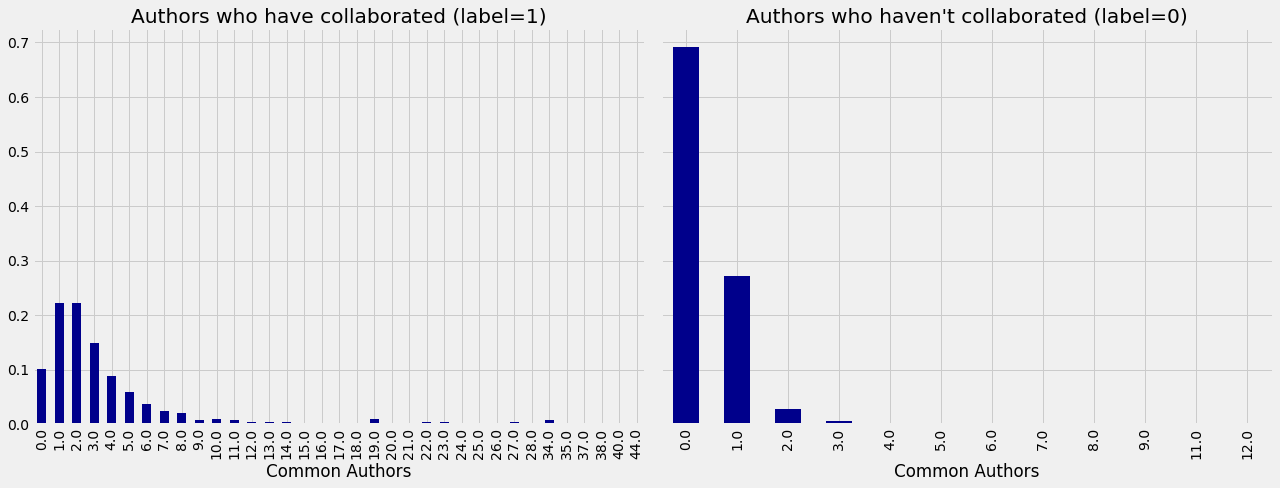

In [39]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]

for index, chart in enumerate(charts):
  label, title = chart
  filtered = training_data.filter(training_data["label"] == label)
  common_authors = filtered.toPandas()["commonAuthors"]
  histogram = common_authors.value_counts().sort_index()
  histogram /= float(histogram.sum())
  histogram.plot(kind="bar", x='Common Authors', color="darkblue",
  ax=axs[index], title=f"Authors who {title} (label={label})")
  axs[index].xaxis.set_label_text("Common Authors")
  
plt.tight_layout()
plt.show()

In [40]:
def train_model(fields, training_data):
  pipeline = create_pipeline(fields)
  model = pipeline.fit(training_data)
  return model

### Creating very basic model with only common authors (neighbours).

In [41]:
basic_model = train_model(["commonAuthors"], training_data)

In [42]:
eval_df = spark.createDataFrame(
[(0,), (1,), (2,), (10,), (100,)],
['commonAuthors'])
(basic_model.transform(eval_df)
.select("commonAuthors", "probability", "prediction")
.show(truncate=False))

+-------------+----------------------------------------+----------+
|commonAuthors|probability                             |prediction|
+-------------+----------------------------------------+----------+
|0            |[0.748329325858949,0.25167067414105104] |0.0       |
|1            |[0.748329325858949,0.25167067414105104] |0.0       |
|2            |[0.04991295334970791,0.9500870466502921]|1.0       |
|10           |[0.04991295334970791,0.9500870466502921]|1.0       |
|100          |[0.04991295334970791,0.9500870466502921]|1.0       |
+-------------+----------------------------------------+----------+



### Create a method to evaluate the model

**Metrics:**
- Accuracy
- Precision
- Recall

In [43]:
def evaluate_model(model, test_data):
  # Execute the model against the test set
  predictions = model.transform(test_data)
  # Compute true positive, false positive, false negative counts
  tp = predictions[(predictions.label == 1) &
  (predictions.prediction == 1)].count()
  fp = predictions[(predictions.label == 0) &
  (predictions.prediction == 1)].count()
  fn = predictions[(predictions.label == 1) &
  (predictions.prediction == 0)].count()
  # Compute recall and precision manually
  recall = float(tp) / (tp + fn)
  precision = float(tp) / (tp + fp)
  # Compute accuracy using Spark MLLib's binary classification evaluator
  accuracy = BinaryClassificationEvaluator().evaluate(predictions)
  # Compute false positive rate and true positive rate using sklearn functions
  labels = [row["label"] for row in predictions.select("label").collect()]
  preds = [row["probability"][1] for row in predictions.select
  ("probability").collect()]
  fpr, tpr, threshold = roc_curve(labels, preds)
  roc_auc = auc(fpr, tpr)
  return { "fpr": fpr, "tpr": tpr, "roc_auc": roc_auc, "accuracy": accuracy,
  "recall": recall, "precision": precision }

In [44]:
def display_results(results):
  results = {k: v for k, v in results.items() if k not in
  ["fpr", "tpr", "roc_auc"]}
  return pd.DataFrame({"Measure": list(results.keys()),
  "Score": list(results.values())})

In [45]:
basic_results = evaluate_model(basic_model, test_data)

In [46]:
display_results(basic_results)

,Measure,Score
0,accuracy,0.855785
1,recall,0.730584
2,precision,0.974635


In [47]:
def create_roc_plot():
  plt.style.use('classic')
  fig = plt.figure(figsize=(13, 8))
  plt.xlim([0, 1])
  plt.ylim([0, 1])
  plt.ylabel('True Positive Rate')
  plt.xlabel('False Positive Rate')
  plt.rc('axes', prop_cycle=(cycler('color',['r', 'g', 'b', 'c', 'm', 'y', 'k'])))
  plt.plot([0, 1], [0, 1], linestyle='--', label='Random score(AUC = 0.50)')
  return plt, fig

def add_curve(plt, title, fpr, tpr, roc):
  plt.plot(fpr, tpr, label=f"{title} (AUC = {roc:0.2})")

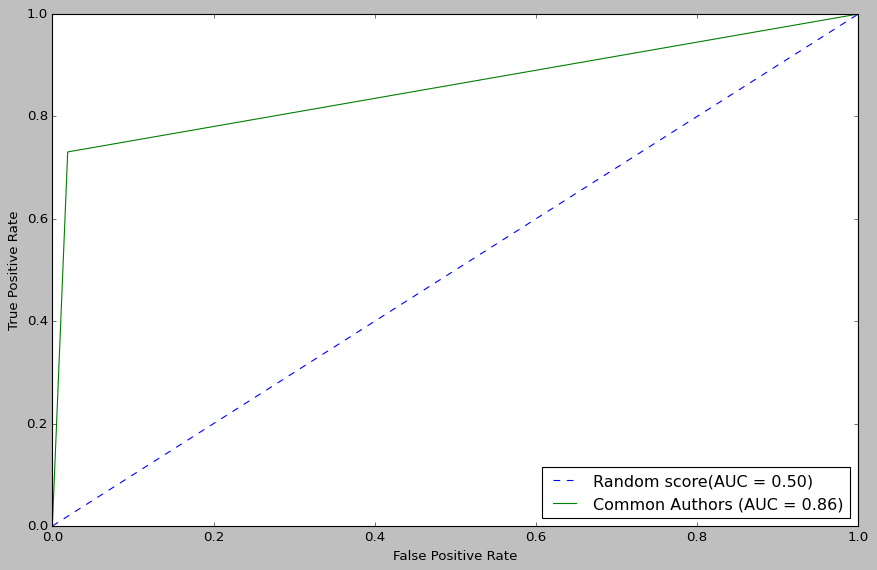

In [48]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Authors",
basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])
plt.legend(loc='lower right')
plt.show()

### Summary for properties CN, PA, TN for labels 0 (Negative edge) and 1 (Positive edge)

In [49]:
(training_data.filter(training_data["label"]==1).describe().select("summary", "commonAuthors", "prefAttachment", "totalNeighbours").show())

(training_data.filter(training_data["label"]==0).describe().select("summary", "commonAuthors", "prefAttachment", "totalNeighbours").show())

+-------+------------------+-----------------+------------------+
|summary|     commonAuthors|   prefAttachment|   totalNeighbours|
+-------+------------------+-----------------+------------------+
|  count|             91421|            91421|             91421|
|   mean|3.6062283282834358| 72.7532623795408|10.468349722711412|
| stddev|  4.73850624234804|171.2486772026608| 8.726784478644868|
|    min|               0.0|              1.0|               2.0|
|    max|              44.0|           3150.0|              90.0|
+-------+------------------+-----------------+------------------+

+-------+------------------+-----------------+------------------+
|summary|     commonAuthors|   prefAttachment|   totalNeighbours|
+-------+------------------+-----------------+------------------+
|  count|             91421|            91421|             91421|
|   mean|0.3563404469432625|49.67510746983734|13.315146410562125|
| stddev|0.6128366612344428| 94.7811977894824|10.189786945978476|
|    min|

## Training the model with Common Neighbours, Pref Attachment and Total Neighbours properties and check for different metrics

In [50]:
fields = ["commonAuthors", "prefAttachment", "totalNeighbours"]
graphy_model = train_model(fields, training_data)

In [51]:
graphy_results = evaluate_model(graphy_model, test_data)
display_results(graphy_results)

,Measure,Score
0,accuracy,0.975148
1,recall,0.906615
2,precision,0.951402


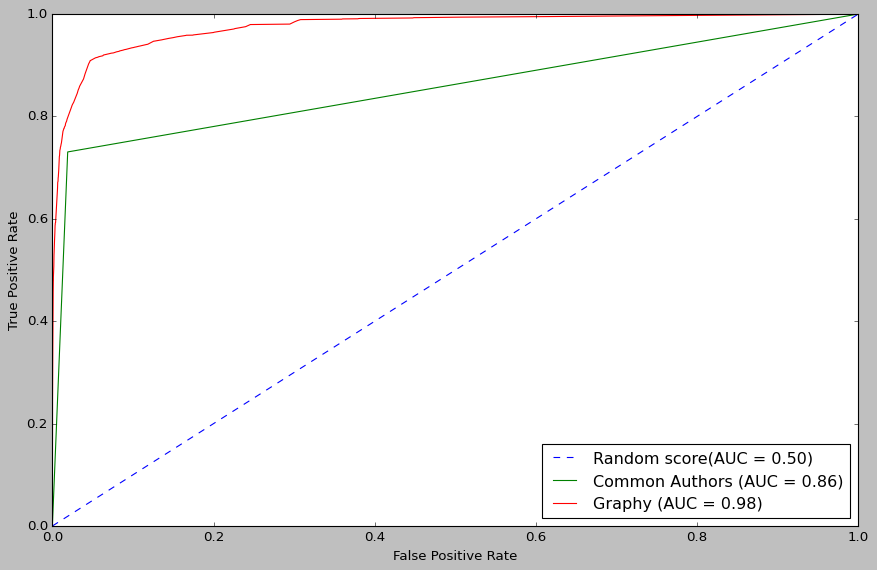

In [52]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Authors",basic_results["fpr"], basic_results["tpr"],basic_results["roc_auc"])
add_curve(plt, "Graphy",graphy_results["fpr"], graphy_results["tpr"],graphy_results["roc_auc"])
plt.legend(loc='lower right')
plt.show()

### Plotting the feature importance in our model (with CN, PA and TN)

In [53]:
### Plotting the feature importance in our model (with CN, PA and TN)def plot_feature_importance(fields, feature_importances):
  df = pd.DataFrame({"Feature": fields, "Importance": feature_importances})
  df = df.sort_values("Importance", ascending=False)
  ax = df.plot(kind='bar', x='Feature', y='Importance', legend=None)
  ax.xaxis.set_label_text("")
  plt.tight_layout()
  plt.show()

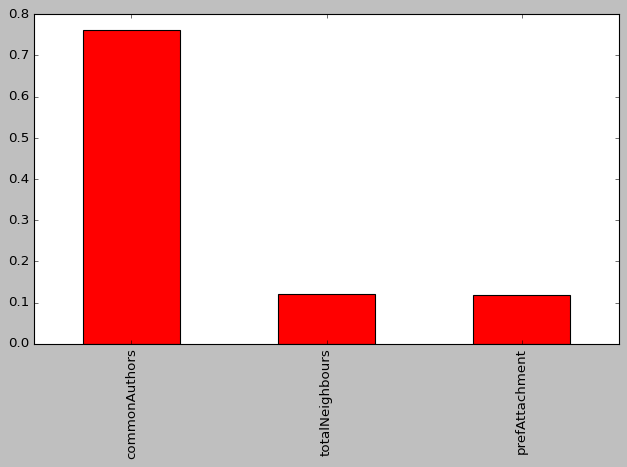

In [54]:
rf_model = graphy_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)

## Predicting Links: Triangles and the Clustering Coefficient

Using triangle coefficient methods provided by neo4j on our model.

- **Cypher queries for early and full co-author graphs for Triangle Count.**

`
CALL gds.triangleCount.write({
nodeProjection: 'Author',
relationshipProjection: {
CO_AUTHOR_EARLY: {
type: 'CO_AUTHOR_EARLY',
orientation: 'UNDIRECTED'
}
},
writeProperty: 'trianglesTrain'
});
`

`
CALL gds.triangleCount.write({
nodeProjection: 'Author',
relationshipProjection: {
CO_AUTHOR: {
type: 'CO_AUTHOR',
orientation: 'UNDIRECTED'
}
},
writeProperty: 'trianglesTest'
});
`

- **Cypher queries for early and full co-author graphs for Local Clustering Coefficient.**

`
CALL gds.localClusteringCoefficient.write({
nodeProjection: 'Author',
relationshipProjection: {
CO_AUTHOR_EARLY: {
type: 'CO_AUTHOR_EARLY',
orientation: 'UNDIRECTED'
}
},
writeProperty: 'coefficientTrain'
});
`

`
CALL gds.localClusteringCoefficient.write({
nodeProjection: 'Author',
relationshipProjection: {
CO_AUTHOR: {
type: 'CO_AUTHOR',
orientation: 'UNDIRECTED'
}
},
writeProperty: 'coefficientTest'
});
`


In [58]:
def apply_triangles_features(data, triangles_prop, coefficient_prop):
  query = """
  UNWIND $pairs AS pair
  MATCH (p1) WHERE id(p1) = pair.node1
  MATCH (p2) WHERE id(p2) = pair.node2
  RETURN pair.node1 AS node1,
  pair.node2 AS node2,
  apoc.coll.min([p1[$trianglesProp], p2[$trianglesProp]])
  AS minTriangles,
  apoc.coll.max([p1[$trianglesProp], p2[$trianglesProp]])
  AS maxTriangles,
  apoc.coll.min([p1[$coefficientProp], p2[$coefficientProp]])
  AS minCoefficient,
  apoc.coll.max([p1[$coefficientProp], p2[$coefficientProp]])
  AS maxCoefficient
  """
  params = {
  "pairs": [{"node1": row["node1"], "node2": row["node2"]}
  for row in data.collect()],
  "trianglesProp": triangles_prop,
  "coefficientProp": coefficient_prop
  }
  features = spark.createDataFrame(graph.run(query, params).to_data_frame())
  return data.join(features, ["node1", "node2"])

In [60]:
training_data = apply_triangles_features(training_data,"trianglesTrain", "coefficientTrain")

In [62]:
test_data = apply_triangles_features(test_data,"trianglesTest", "coefficientTest")

### Summary for properties of Triangle Coefficients

In [63]:
(training_data.filter(training_data["label"]==1).describe().select("summary", "minTriangles", "maxTriangles","minCoefficient", "maxCoefficient").show())

(training_data.filter(training_data["label"]==0).describe().select("summary", "minTriangles", "maxTriangles", "minCoefficient","maxCoefficient").show())

+-------+------------------+-----------------+-------------------+------------------+
|summary|      minTriangles|     maxTriangles|     minCoefficient|    maxCoefficient|
+-------+------------------+-----------------+-------------------+------------------+
|  count|             91421|            91421|              91421|             91421|
|   mean|18.659006136445676|26.39837674057383| 0.5165805583432915|0.7845600742340463|
| stddev| 62.14817403207152|70.43599299164589|0.37719528437107075|0.3275431882536984|
|    min|                 0|                0|                0.0|               0.0|
|    max|               610|              762|                1.0|               1.0|
+-------+------------------+-----------------+-------------------+------------------+

+-------+------------------+------------------+-------------------+------------------+
|summary|      minTriangles|      maxTriangles|     minCoefficient|    maxCoefficient|
+-------+------------------+------------------+----

### Training the model with Common Neighbours, Pref Attachment, Total Neighbours and Triangle Coefficient properties and check for different metrics.

In [64]:
fields = ["commonAuthors", "prefAttachment", "totalNeighbours","minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient"]
triangle_model = train_model(fields, training_data)

In [65]:
triangle_results = evaluate_model(triangle_model, test_data)
display_results(triangle_results)

,Measure,Score
0,accuracy,0.989776
1,recall,0.938772
2,precision,0.958171


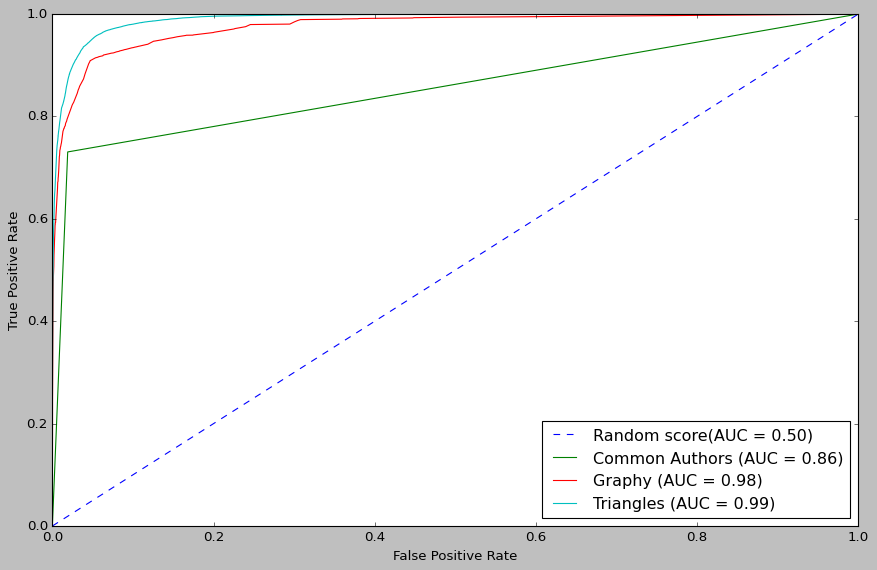

In [66]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Authors",basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])
add_curve(plt, "Graphy",graphy_results["fpr"], graphy_results["tpr"],graphy_results["roc_auc"])
add_curve(plt, "Triangles",triangle_results["fpr"], triangle_results["tpr"],triangle_results["roc_auc"])
plt.legend(loc='lower right')
plt.show()

### Plotting the feature importance in our model (with CN, PA, TN and Triangle Coefficients)

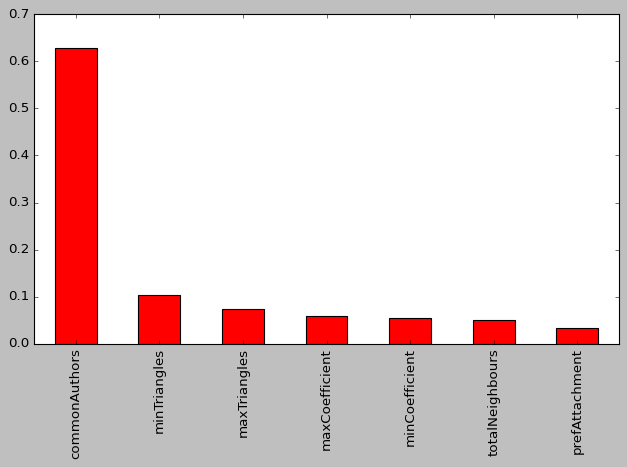

In [67]:
rf_model = triangle_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)

## Predicting Links: Community Detection

Using community detection methods provided by neo4j on our model.

- **Cypher queries for early and full co-author graphs for Label Propagation.**

`
CALL gds.labelPropagation.write({
nodeProjection: "Author",
relationshipProjection: {
CO_AUTHOR_EARLY: {
type: 'CO_AUTHOR_EARLY',
orientation: 'UNDIRECTED'
}
},
writeProperty: "partitionTrain"
});
`

`
CALL gds.labelPropagation.write({
nodeProjection: "Author",
relationshipProjection: {
CO_AUTHOR: {
type: 'CO_AUTHOR',
orientation: 'UNDIRECTED'
}
},
writeProperty: "partitionTest"
});
`

- **Cypher queries for early and full co-author graphs for Louvain algorithm.**

`
CALL gds.louvain.stream({
nodeProjection: 'Author',
relationshipProjection: {
CO_AUTHOR_EARLY: {
type: 'CO_AUTHOR_EARLY',
orientation: 'UNDIRECTED'
}
},
includeIntermediateCommunities: true
})
YIELD nodeId, communityId, intermediateCommunityIds
WITH gds.util.asNode(nodeId) AS node,
intermediateCommunityIds[0] AS smallestCommunity
SET node.louvainTrain = smallestCommunity;
`

`
CALL gds.louvain.stream({
nodeProjection: 'Author',
relationshipProjection: {
CO_AUTHOR: {
type: 'CO_AUTHOR',
orientation: 'UNDIRECTED'
}
},
includeIntermediateCommunities: true
})
YIELD nodeId, communityId, intermediateCommunityIds
WITH gds.util.asNode(nodeId) AS node,
intermediateCommunityIds[0] AS smallestCommunity
SET node.louvainTest = smallestCommunity;
`

In [ ]:
# Community detection methods

In [68]:
def apply_community_features(data, partition_prop, louvain_prop):
  query = """
  UNWIND $pairs AS pair
  MATCH (p1) WHERE id(p1) = pair.node1
  MATCH (p2) WHERE id(p2) = pair.node2
  RETURN pair.node1 AS node1,
  pair.node2 AS node2,
  CASE WHEN p1[$partitionProp] = p2[$partitionProp] THEN
  1 ELSE 0 END AS samePartition,
  CASE WHEN p1[$louvainProp] = p2[$louvainProp] THEN
  1 ELSE 0 END AS sameLouvain
  """
  params = {"pairs": [{"node1": row["node1"], "node2": row["node2"]} for row in data.collect()],"partitionProp": partition_prop,"louvainProp": louvain_prop}
  features = spark.createDataFrame(graph.run(query, params).to_data_frame())
  return data.join(features, ["node1", "node2"])

In [70]:
training_data = apply_community_features(training_data,"partitionTrain", "louvainTrain")

In [72]:
test_data = apply_community_features(test_data, "partitionTest", "louvainTest")

In [73]:
import pyspark.sql.functions as F

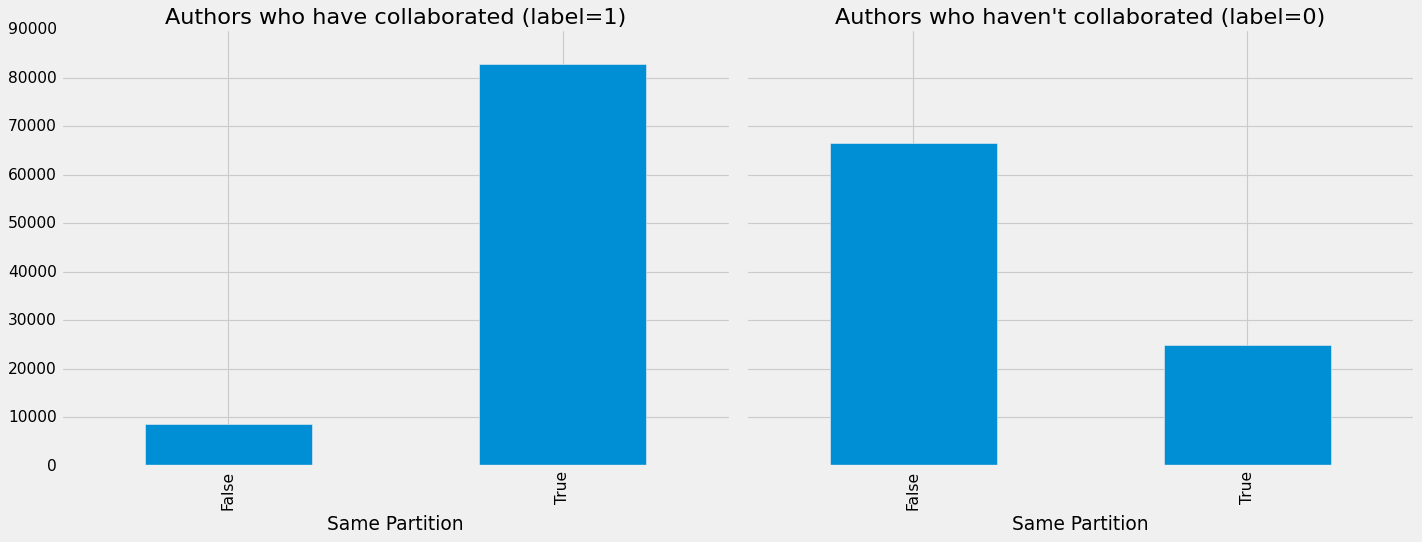

In [74]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]

for index, chart in enumerate(charts):
  label, title = chart
  filtered = training_data.filter(training_data["label"] == label)
  values = (filtered.withColumn('samePartition',
  F.when(F.col("samePartition") == 0, "False")
  .otherwise("True"))
  .groupby("samePartition")
  .agg(F.count("label").alias("count"))
  .select("samePartition", "count")
  .toPandas())
  values.set_index("samePartition", drop=True, inplace=True)
  values.plot(kind="bar", ax=axs[index], legend=None,
  title=f"Authors who {title} (label={label})")
  axs[index].xaxis.set_label_text("Same Partition")

plt.tight_layout()
plt.show()

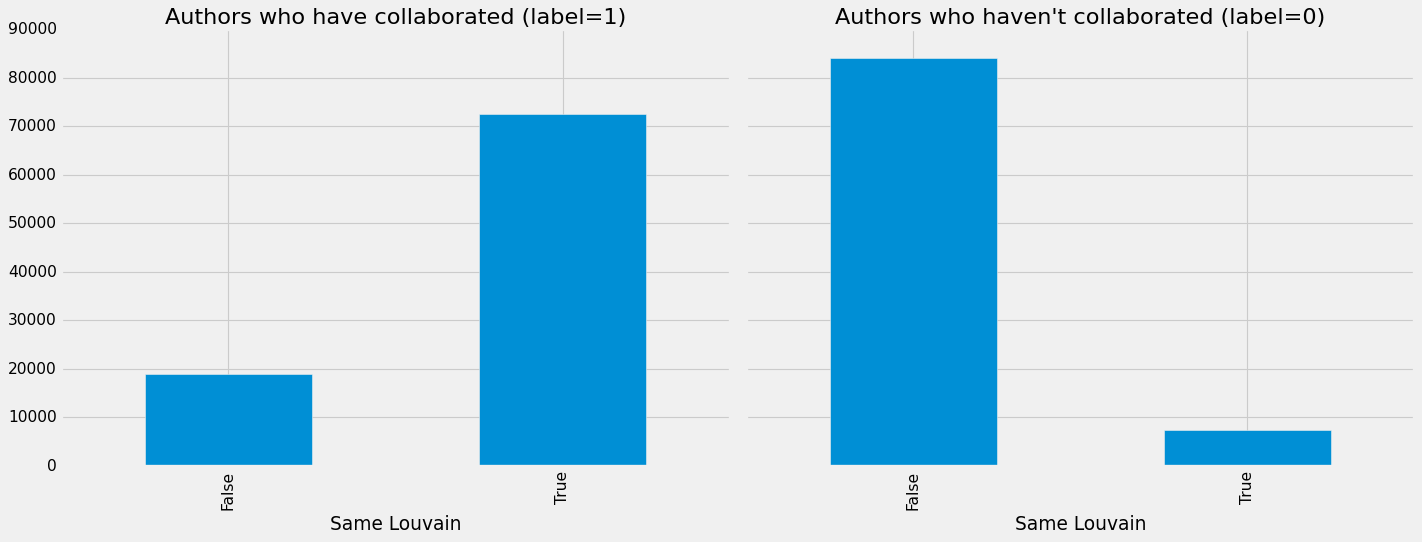

In [75]:
plt.style.use('fivethirtyeight')
fig, axs = plt.subplots(1, 2, figsize=(18, 7), sharey=True)
charts = [(1, "have collaborated"), (0, "haven't collaborated")]

for index, chart in enumerate(charts):
  label, title = chart
  filtered = training_data.filter(training_data["label"] == label)
  values = (filtered.withColumn('sameLouvain',
  F.when(F.col("sameLouvain") == 0, "False")
  .otherwise("True"))
  .groupby("sameLouvain")
  .agg(F.count("label").alias("count"))
  .select("sameLouvain", "count")
  .toPandas())
  values.set_index("sameLouvain", drop=True, inplace=True)
  values.plot(kind="bar", ax=axs[index], legend=None,
  title=f"Authors who {title} (label={label})")
  axs[index].xaxis.set_label_text("Same Louvain")
  
plt.tight_layout()
plt.show()

### Training the model with Common Neighbours, Pref Attachment, Total Neighbours, Triangle Coefficient and Community Detection properties and check for different metrics.

In [76]:
fields = ["commonAuthors", "prefAttachment", "totalNeighbours","minTriangles", "maxTriangles", "minCoefficient", "maxCoefficient","samePartition", "sameLouvain"]
community_model = train_model(fields, training_data)

In [77]:
community_results = evaluate_model(community_model, test_data)
display_results(community_results)

,Measure,Score
0,accuracy,0.994621
1,recall,0.957802
2,precision,0.979046


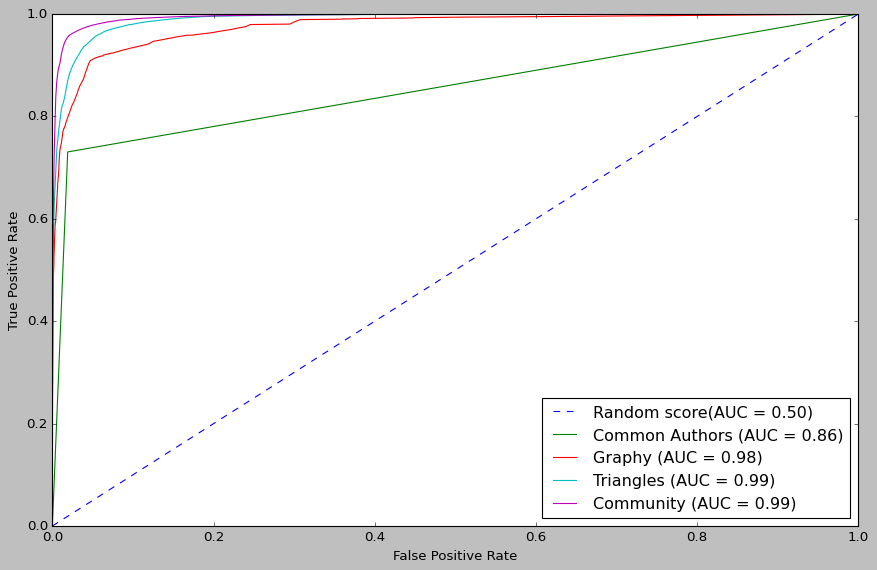

In [78]:
plt, fig = create_roc_plot()
add_curve(plt, "Common Authors",basic_results["fpr"], basic_results["tpr"], basic_results["roc_auc"])
add_curve(plt, "Graphy",graphy_results["fpr"], graphy_results["tpr"],graphy_results["roc_auc"])
add_curve(plt, "Triangles",triangle_results["fpr"], triangle_results["tpr"],triangle_results["roc_auc"])
add_curve(plt, "Community",community_results["fpr"], community_results["tpr"],community_results["roc_auc"])

plt.legend(loc='lower right')
plt.show()

### Plotting the feature importance in our model (with CN, PA, TN , Triangle Coefficients and Community Detection Algos)

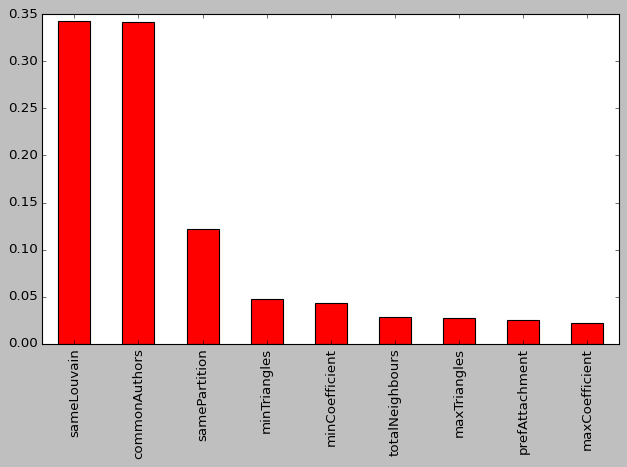

In [79]:
rf_model = community_model.stages[-1]
plot_feature_importance(fields, rf_model.featureImportances)